# 通用量化模型

```{rubric} 模型对比
```

类型|大小（MB）|accuracy（$\%$）
:-|:-|:-
浮点|9.188|95.09
浮点融合|8.924|95.09
QAT|2.657|94.86

```{rubric} 不同 QConfig 的静态 PTQ 模型
```

accuracy（$\%$）|激活|权重|
:-|:-|:-
|40.51|{data}`~torch.ao.quantization.observer.MinMaxObserver`.`with_args(quant_min=0, quant_max=127)`|{data}`~torch.ao.quantization.observer.MinMaxObserver`.`with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric)`
75.68|{data}`~torch.ao.quantization.observer.HistogramObserver`.`with_args(quant_min=0, quant_max=127)`|{data}`~torch.ao.quantization.observer.PerChannelMinMaxObserver`.`with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric)`

加载一些库：

In [1]:
from torch import nn, jit
from torch.ao.quantization.qconfig import default_qconfig
from torch.ao.quantization.qconfig import get_default_qat_qconfig, get_default_qconfig
from torch.ao.quantization.quantize import prepare, convert, prepare_qat
import torch

# 设置 warnings

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module='.*'
)
warnings.filterwarnings(
    action='ignore',
    module='torch.ao.quantization'
)
# 载入自定义模块
from mod import load_mod
load_mod()

设置模型保存路径和超参数：

In [2]:
saved_model_dir = 'models/'
float_model_file = 'mobilenet_pretrained_float.pth'
scripted_float_model_file = 'mobilenet_float_scripted.pth'
scripted_ptq_model_file = 'mobilenet_ptq_scripted.pth'
scripted_quantized_model_file = 'mobilenet_quantization_scripted_quantized.pth'
scripted_qat_model_file = 'mobilenet_qat_scripted_quantized.pth'
# 超参数
learning_rate = 5e-5
num_epochs = 30
batch_size = 16
num_classes = 10
# train_batch_size = 30
# eval_batch_size = 50

# 设置评估策略
criterion = nn.CrossEntropyLoss()

## 辅助函数

接下来，我们定义几个[帮助函数](https://github.com/pytorch/examples/blob/master/imagenet/main.py)来帮助评估模型。

In [3]:
from helper import evaluate, print_size_of_model, load_model


def print_info(model, model_type='浮点模型'):
    '''打印信息'''
    print_size_of_model(model)
    top1, top5 = evaluate(model, criterion, test_iter)
    print(f'\n{model_type}：\n\t'
          f'在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.5f}')

## 定义数据集和数据加载器

作为最后一个主要的设置步骤，我们为训练和测试集定义了数据加载器。

In [4]:
from xinet import CV

# 为了 cifar10 匹配 ImageNet，需要将其 resize 到 224
train_iter, test_iter = CV.load_data_cifar10(batch_size=batch_size,
                                             resize=224)

Files already downloaded and verified
Files already downloaded and verified


查看数据集的 batch 次数：

In [5]:
print('训练、测试批次分别为：',
      len(train_iter), len(test_iter))


训练、测试批次分别为： 3125 625


获取训练和测试数据集的大小：

In [6]:
# num_train = sum(len(ys) for _, ys in train_iter)
num_eval = sum(len(ys) for _, ys in test_iter)
# num_train, 
num_eval

10000

## 微调浮点模型

配置浮点模型：

In [7]:
from torchvision.models.quantization import mobilenet_v2

# 定义模型
def create_model(quantize=False,
                 num_classes=10,
                 pretrained=False):
    float_model = mobilenet_v2(pretrained=pretrained,
                               quantize=quantize)
    # 匹配 ``num_classes``
    float_model.classifier[1] = nn.Linear(float_model.last_channel,
                                          num_classes)
    return float_model

定义模型：

In [ ]:
float_model = create_model(pretrained=True,
                           quantize=False,
                           num_classes=num_classes)

微调浮点模型：

In [ ]:
CV.train_fine_tuning(float_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device='cuda:0',
                     param_group=True)

保存模型：

In [ ]:
torch.save(float_model.state_dict(), saved_model_dir + float_model_file)

## 配置可量化模型

加载浮点模型：

In [ ]:
float_model = create_model(quantize=False,
                           num_classes=num_classes)
float_model = load_model(float_model, saved_model_dir + float_model_file)

查看浮点模型的信息：

In [ ]:
print_info(float_model, model_type='浮点模型')


```{rubric} 融合模块
```

融合模块既可以节省内存访问，使模型更快，同时也提高了数值精度。虽然这可以用于任何模型，但这在量化模型中尤其常见。

可以先查看融合前的 inverted residual 块：

In [ ]:
float_model.features[1].conv

启用评估模式：

In [ ]:
float_model.eval();

融合模块：

In [ ]:
float_model.fuse_model()

查看融合后的 inverted residual 块：

In [ ]:
float_model.features[1].conv

最后，为了得到“基线”精度，让我们看看融合模块的非量化模型的精度：

In [ ]:
model_type = '融合后的浮点模型'
print("baseline 模型大小")
print_size_of_model(float_model)

top1, top5 = evaluate(float_model, criterion, test_iter)

In [ ]:
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.3f}')
# 保存
jit.save(jit.script(float_model), saved_model_dir + scripted_float_model_file)

这将是我们进行比较的基准。接下来，让我们尝试不同的量化方法。

## 静态量化后训练

训练后的静态量化（Post Training Quantization，简称 PTQ）不仅包括将权重从 float 转换为int，就像在动态量化中一样，还包括执行额外的步骤，即首先通过网络输入一批数据，并计算不同激活的结果分布（具体来说，这是通过在记录数据的不同点插入观测者模块来实现的）。然后使用这些分布来确定如何在推断时量化不同的激活（一种简单的技术是将整个激活范围划分为 256 个级别，但我们也支持更复杂的方法）。重要的是，这个额外的步骤允许我们在运算之间传递量化的值，而不是在每个运算之间将这些值转换为浮点数（然后再转换为整数），从而显著提高了速度。

In [ ]:
# 加载模型
myModel = create_model(pretrained=False,
                       quantize=False,
                       num_classes=num_classes)
float_model = load_model(myModel,
                         saved_model_dir + float_model_file)
myModel.eval()

# 融合
myModel.fuse_model()

指定量化配置（从简单的最小/最大范围估计和加权的逐张量量化开始）：

In [ ]:
myModel.qconfig = default_qconfig
myModel.qconfig

开始校准准备：

In [ ]:
print('PTQ 准备：插入观测者')
prepare(myModel, inplace=True)
print('\n 查看观测者插入后的 inverted residual \n\n',
      myModel.features[1].conv)

用数据集校准：

In [ ]:
num_calibration_batches = -1 # 取全部训练集做校准
evaluate(myModel, criterion, train_iter, neval_batches=num_calibration_batches)
print('\nPTQ：校准完成！')

转换为量化模型：

In [ ]:
convert(myModel, inplace=True)
print('PTQ：转换完成！')

融合并量化后，查看融合模块的 Inverted Residual 块：

In [ ]:
myModel.features[1].conv

量化后的模型大小：

In [ ]:
print_size_of_model(myModel)

评估：

In [ ]:
model_type = 'PTQ 模型'
top1, top5 = evaluate(myModel, criterion, test_iter)
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.2f}')
jit.save(jit.script(float_model), saved_model_dir + scripted_ptq_model_file)

这是因为我们使用了简单的 min/max 观测器来确定量化参数。尽管如此，我们还是将模型的大小减少到了 2.36 MB 以下，几乎减少了 4 倍。

此外，通过使用不同的量化配置来显著提高精度（对于量化 ARM 架构的推荐配置重复同样的练习）。该配置的操作如下：

- 在 per-channel 基础上量化权重
- 使用直方图观测器，收集激活的直方图，然后以最佳方式选择量化参数。

In [ ]:
per_channel_quantized_model = create_model(quantize=False,
                                           num_classes=num_classes)
per_channel_quantized_model = load_model(per_channel_quantized_model,
                                         saved_model_dir + float_model_file)
per_channel_quantized_model.eval()
per_channel_quantized_model.fuse_model()
per_channel_quantized_model.qconfig = get_default_qconfig('fbgemm')
per_channel_quantized_model.qconfig

In [ ]:
num_calibration_batches = 200 # 仅仅取 200 个批次
prepare(per_channel_quantized_model, inplace=True)
evaluate(per_channel_quantized_model, criterion,
         train_iter, num_calibration_batches)

model_type = 'PTQ 模型（直方图观测器）'
convert(per_channel_quantized_model, inplace=True)
top1, top5 = evaluate(per_channel_quantized_model, criterion, test_iter)

In [ ]:
print(f'\n{model_type}：\n\t在 {num_eval} 张图片上评估 accuracy 为: {top1.avg:2.2f}')
jit.save(jit.script(per_channel_quantized_model),
         saved_model_dir + scripted_quantized_model_file)

仅仅改变这种量化配置方法，就可以将准确度提高到 $75.6\%$ 以上！尽管如此，这还是比 $95.09\%$ 的基线水平低了 $19\%$。让我们尝试量化感知训练。

## 量化感知训练

量化感知训练（Quantization-aware training，QAT）是一种量化方法，通常可以获得最高的精度。使用 QAT，所有的权值和激活都在前向和后向训练过程中被“伪量化”：也就是说，浮点值被舍入以模拟 int8 值，但所有的计算仍然使用浮点数完成。因此，训练过程中的所有权重调整都是在“感知到”模型最终将被量化的情况下进行的；因此，在量化之后，这种方法通常比动态量化或训练后的静态量化产生更高的精度。

实际执行 QAT 的总体工作流程与之前非常相似：

- 可以使用与以前相同的模型：不需要为量化感知训练做额外的准备。
- 需要使用 `qconfig` 来指定在权重和激活之后插入何种类型的伪量化，而不是指定观测者。

In [8]:
def create_qat_model(num_classes,
                     model_path=saved_model_dir+'old/'+float_model_file,
                     quantize=False,
                     backend='fbgemm'):
    qat_model = create_model(quantize=quantize,
                             num_classes=num_classes)
    qat_model = load_model(qat_model, model_path)
    qat_model.fuse_model()
    qat_model.qconfig = get_default_qat_qconfig(backend=backend)
    return qat_model

最后，`prepare_qat` 执行“伪量化”，为量化感知训练准备模型：

In [9]:
qat_model = create_qat_model(num_classes)
qat_model = prepare_qat(qat_model)

Inverted Residual Block：准备好 QAT 后，注意伪量化模块：

In [10]:
qat_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): ConvBnReLU2d(
      32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
      )
      (activation_post_process): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
        (activation_post_process): MovingAver

训练具有高精确度的量化模型要求在推理时对数值进行精确的建模。因此，对于量化感知训练，我们对训练循环进行如下修改：

- 将批处理范数转换为训练结束时的运行均值和方差，以更好地匹配推理数值。
- 冻结量化器参数（尺度和零点）并微调权重。

loss 0.011, train acc 0.996, test acc 0.950
171.4 examples/sec on cuda:1


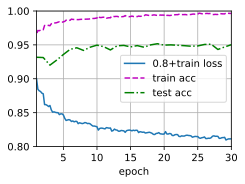

In [11]:
CV.train_fine_tuning(qat_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=30,
                     device='cuda:1',
                     param_group=True,
                     is_freeze=False,
                     is_quantized_acc=False,
                     need_prepare=False,
                     ylim=[0.8, 1])

In [ ]:
convert(qat_model.cpu().eval(), inplace=True)
qat_model.eval();

In [ ]:
print_info(qat_model,'QAT 模型')

量化感知训练在整个 imagenet 数据集上的准确率超过 $94.86\%$，接近浮点精度 $95.09\%$。

更多关于 QAT 的内容：

- QAT 是后训练量化技术的超集，允许更多的调试。例如，我们可以分析模型的准确性是否受到权重或激活量化的限制。
- 也可以在浮点上模拟量化模型的准确性，因为使用伪量化来模拟实际量化算法的数值。
- 也可以很容易地模拟训练后量化。

保存 QAT 模型：

In [ ]:
jit.save(jit.script(qat_model), saved_model_dir + scripted_qat_model_file)

## 量化加速（待更，当前有问题）

最后，确认上面提到的一些事情：量化模型实际上执行推断更快吗？

In [ ]:
import time

def run_benchmark(model_file, img_loader):
    elapsed = 0
    model = torch.jit.load(model_file)
    model.eval()
    num_batches = 5
    # Run the scripted model on a few batches of images
    for i, (images, target) in enumerate(img_loader):
        if i < num_batches:
            start = time.time()
            output = model(images)
            end = time.time()
            elapsed = elapsed + (end-start)
        else:
            break
    num_images = images.size()[0] * num_batches

    print('Elapsed time: %3.0f ms' % (elapsed/num_images*1000))
    return elapsed

run_benchmark(saved_model_dir + scripted_float_model_file, test_iter)
run_benchmark(saved_model_dir + scripted_qat_model_file, test_iter)

在本地运行，常规模型的速度为 15 毫秒，量化模型的速度仅为 20 毫秒，这说明了量化模型与浮点模型相比，典型的 2-4 倍的加速。